In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')

2021-12-21 15:01:59.181394: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import sys 
sys.path.append("/scratch/izar/kapps/DEX-Cyclic-Arbitrage/")
from config.get import cfg

# Data loading & preprocessing

## Transform `tokens` into dummy variables (one hot encoding)

In [13]:
# transform tokens into dummies
from sklearn.preprocessing import OneHotEncoder
token_columns = list(filter(lambda c: c.startswith('token'),log_data.columns))
def one_hot_tokens():
    one_enc = OneHotEncoder(sparse=False) 
    unique_tokens = np.unique(pd.concat([log_data[token] for token in token_columns],axis=0))
    one_enc.fit(unique_tokens.reshape(-1, 1))
    # transform
    encode = lambda col: one_enc.transform(log_data[col].to_numpy().reshape(-1, 1))
    # encode and convert as dataframes
    
    encoded = [pd.DataFrame(encode(token)).add_prefix(f"token_{key}_") for key,token in enumerate(token_columns)]
    return pd.concat(encoded, axis='columns')

In [14]:
X = pd.concat([log_data.drop(columns=token_columns),one_hot_tokens()], axis='columns')

KeyboardInterrupt: 

#  Transform each cycle into a feature matrix  & Zero-padding

In [4]:
X = np.load(cfg['files']["raw_features"])

In [5]:
from sklearn.model_selection import train_test_split
# train/test split and standard scaling 
test_size = 0.3
N =  X.shape[0]
N_train = int(N * (1 - test_size))
X_train, X_test, train_id, test_id = train_test_split(X, np.arange(X.shape[0]),test_size=test_size, random_state=123)


#scaler = StandardScaler()
#scaler.fit(X_train)

#X_train_scaled = scaler.transform(X_train)
#X_test_scaled  = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

In [24]:
np.save(cfg['files']['raw_test_features'] , X_test)
np.save(cfg['files']['raw_train_features'] ,X_train)
np.save(cfg['files']['raw_test_ids'] , test_id)
np.save(cfg['files']['raw_train_ids'] , train_id)

# Model definition

In [6]:
def build_model():
    input_img = keras.Input(shape=(3,600, 2))
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((3, 3), padding='same')(x)
    x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(1, (2, 2), activation='relu', padding='same')(x)
    # at this point the representation is 100-dimensional
    x = layers.Conv2D(4, (2, 2), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((1, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((3, 3))(x)
    decoded = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', metrics=['accuracy'],loss='mean_squared_error',)
    
    return autoencoder

In [7]:
autoencoder = build_model()
autoencoder.summary()

2021-12-21 15:02:20.413863: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-21 15:02:20.625999: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-21 15:02:20.626040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (izar): /proc/driver/nvidia/version does not exist


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 600, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 600, 8)         152       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 200, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 200, 4)         292       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 100, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 100, 1)         17        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 100, 4)        

Epoch 1/100
90/90 [==============================] - 10s 117ms/step - loss: 54098.7344 - accuracy: 0.8029
Epoch 2/100
90/90 [==============================] - 10s 110ms/step - loss: 36887.2656 - accuracy: 0.8141
Epoch 3/100
90/90 [==============================] - 10s 107ms/step - loss: 35729.7266 - accuracy: 0.8141
Epoch 4/100
90/90 [==============================] - 10s 108ms/step - loss: 35427.8008 - accuracy: 0.8141
Epoch 5/100
90/90 [==============================] - 10s 108ms/step - loss: 35287.6328 - accuracy: 0.8141
Epoch 6/100
90/90 [==============================] - 10s 109ms/step - loss: 35187.2227 - accuracy: 0.8141
Epoch 7/100
90/90 [==============================] - 10s 108ms/step - loss: 35129.7500 - accuracy: 0.8141
Epoch 8/100
90/90 [==============================] - 10s 108ms/step - loss: 35063.3984 - accuracy: 0.8141
Epoch 9/100
90/90 [==============================] - 10s 108ms/step - loss: 35020.9531 - accuracy: 0.8141
Epoch 10/100
90/90 [==========================

90/90 [==============================] - 10s 107ms/step - loss: 25782.6641 - accuracy: 0.7984s - loss: 25834
Epoch 77/100
90/90 [==============================] - 10s 107ms/step - loss: 25770.3652 - accuracy: 0.7985
Epoch 78/100
90/90 [==============================] - 10s 107ms/step - loss: 25792.7578 - accuracy: 0.7985
Epoch 79/100
90/90 [==============================] - 10s 106ms/step - loss: 25731.7129 - accuracy: 0.7984
Epoch 80/100
90/90 [==============================] - 10s 107ms/step - loss: 25786.8555 - accuracy: 0.7988
Epoch 81/100
90/90 [==============================] - 10s 106ms/step - loss: 25766.4883 - accuracy: 0.7988
Epoch 82/100
90/90 [==============================] - 10s 106ms/step - loss: 25691.6680 - accuracy: 0.7990
Epoch 83/100
90/90 [==============================] - 10s 107ms/step - loss: 25679.7969 - accuracy: 0.7990
Epoch 84/100
90/90 [==============================] - 10s 106ms/step - loss: 25682.1367 - accuracy: 0.7990
Epoch 85/100
90/90 [===============

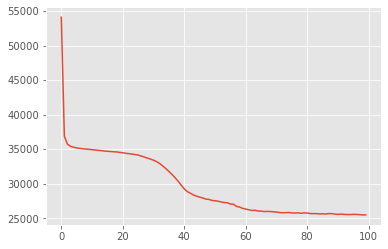

In [9]:
hist = autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=100,
                batch_size=32,
                shuffle=True,
                verbose=1)
plt.plot(hist.history["loss"])
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
def print_mse(compute_pred = lambda x :autoencoder.predict(x)):
    ae_of_train = mean_squared_error(X_train_scaled.reshape(-1),compute_pred(X_train_scaled).reshape(-1))
    ae_of_test = mean_squared_error(X_test_scaled.reshape(-1), compute_pred(X_test_scaled).reshape(-1))
    print(f"MSE train : {ae_of_train} \nMSE test  : {ae_of_test}")
print_mse()

MSE train : 25541.59590293752 
MSE test  : 26834.885744139337


In [11]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=100)
tX_train = X_train_scaled.reshape(N_train,-1)
tX_test = X_test_scaled.reshape(N - N_train,-1)
pca.fit(tX_train)
#print_mse(lambda x: pca.inverse_transform(pca.transform(tX_train)))
pca_train = mean_squared_error(tX_train, pca.inverse_transform(pca.transform(tX_train)))
pca_test =  mean_squared_error(tX_test, pca.inverse_transform(pca.transform(tX_test)))
print(f"MSE train : {pca_train} \nMSE test  : {pca_test}")

MSE train : 1237.185732071038 
MSE test  : 1838.7659055421211


In [12]:
autoencoder.save('autoencoder_model')

2021-12-21 15:20:06.729392: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Load model

In [13]:
autoencoder = keras.models.load_model('autoencoder_model')
X = np.load(cfg['files']["raw_features"])

In [20]:
X[:1]

array([[[[ -5.32015037,  17.99999898],
         [ -4.45695528,  16.99999949],
         [ -4.49284688,  16.99999949],
         ...,
         [ -1.6863906 ,  41.00999987],
         [ -1.66454188,  41.00999987],
         [ -1.6680385 ,  32.99999949]],

        [[  7.29062134,  25.99999898],
         [  9.47089524,  30.00000102],
         [  9.10894194,  28.99999949],
         ...,
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],

        [[-11.6484556 ,  44.23192576],
         [-11.07534862,  35.00000051],
         [-11.04633346, 101.00000358],
         ...,
         [-10.09539986,  20.99999949],
         [-10.08533068,  18.7499991 ],
         [-10.12098522,  28.        ]]]])

In [21]:
autoencoder(X[4:5])

<tf.Tensor: shape=(1, 3, 600, 2), dtype=float32, numpy=
array([[[[ 0.       , 11.931336 ],
         [ 0.       , 11.46713  ],
         [ 0.       , 11.851921 ],
         ...,
         [ 0.       ,  0.       ],
         [ 0.       ,  0.       ],
         [ 0.       ,  0.       ]],

        [[ 0.       , 30.082447 ],
         [ 0.       , 47.8061   ],
         [ 0.       , 29.722042 ],
         ...,
         [ 0.       ,  0.       ],
         [ 0.       ,  0.       ],
         [ 0.       ,  0.       ]],

        [[ 0.       ,  1.2651794],
         [ 0.       ,  0.       ],
         [ 0.       ,  3.905907 ],
         ...,
         [ 0.       ,  0.       ],
         [ 0.       ,  0.       ],
         [ 0.       ,  0.       ]]]], dtype=float32)>

In [22]:
autoencoder(X[100:101])

<tf.Tensor: shape=(1, 3, 600, 2), dtype=float32, numpy=
array([[[[  0.      ,  33.47847 ],
         [  0.      ,  34.10285 ],
         [  0.      ,  34.3735  ],
         ...,
         [  0.      ,   0.      ],
         [  0.      ,   0.      ],
         [  0.      ,   0.      ]],

        [[  0.      ,  92.61729 ],
         [  0.      , 152.37823 ],
         [  0.      , 103.295334],
         ...,
         [  0.      ,   0.      ],
         [  0.      ,   0.      ],
         [  0.      ,   0.      ]],

        [[  0.      ,  10.691814],
         [  0.      ,   0.      ],
         [  0.      ,  27.942345],
         ...,
         [  0.      ,   0.      ],
         [  0.      ,   0.      ],
         [  0.      ,   0.      ]]]], dtype=float32)>

In [6]:
encoding_layer = 5

def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    """extract layers between starting_layer_ix and ending_layer_ix from a given model"""
     # create an empty model
    new_model = keras.Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix + 1):
        curr_layer = main_model.get_layer(index=ix)
    # copy this layer over to the new model
        new_model.add(curr_layer)
    return new_model
# extract en encoder part of the autoencoder
encoder = extract_layers(autoencoder,0,encoding_layer)

In [27]:
X_train = np.load(cfg['files']['raw_train_features'])
np.isnan(X_train).any()
#encoder(X_train)

False

In [8]:
X_train[0].min()

0.0

In [9]:
train_id  =np.load(cfg['files']['train_ids'])

In [10]:
train_id

array([3144, 9939, 7925, ..., 5218, 1346, 3582])

In [12]:
X[3144].min()

0.0

In [45]:
a = []
for i in range(X_train.shape[0]):
    a.append(X_train[i].max())
a = np.array(a)
a.argmax()

672

In [7]:
len(a[a == 0])/len(a)

0.0

In [6]:
a = []
for i in range(X.shape[0]):
    a.append(X[i].max())
a = np.array(a)
a.argmax()

2000

In [32]:
X_train[672]

array([[[11.74618272, 14.        ],
        [11.72472664, 30.00000102],
        [11.68929914, 46.00000102],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-6.44173954, 30.00000102],
        [-6.38766396, 30.00000102],
        [-6.29579457, 28.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[-5.29522908, 12.99999949],
        [-5.29489376, 33.99999898],
        [-5.29439048, 35.99999795],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]])